# Quantum Reservoir Computing: Logistic map

## 1. Install and import (quantum)reservoirpy if needed

This notebook shows how to use a quantum reservoir for time series prediction.
It uses [quantumreservoirpy](https://github.com/OpenQuantumComputing/quantumreservoirpy/) which follows the standard API from [reservoirpy](https://github.com/reservoirpy/reservoirpy).
The underlying procedures are documentet in [this preprint](https://arxiv.org/abs/2407.00445).

In [1]:
import subprocess
import sys

try:
    import quantumreservoirpy  # noqa

    print("quantumreservoirpy is already installed.")
except ImportError:
    print("quantumreservoirpy is not installed. Installing now...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "quantumreservoirpy"])

try:
    import reservoirpy  # noqa

    print("reservoirpy is already installed.")
except ImportError:
    print("reservoirpy is not installed. Installing now...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "reservoirpy"])

quantumreservoirpy is already installed.
reservoirpy is already installed.


## 2. Import other necessary modules

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit_aer import AerSimulator
from quantumreservoirpy.partialmeasurement import PartialMeasurement
from quantumreservoirpy.stabilizer import Stabilizer
from quantumreservoirpy.util import create_shifted_array
from reservoirpy.datasets import logistic_map
from reservoirpy.nodes import Reservoir
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit

## 3. We want to "learn" the [logistic map](https://en.wikipedia.org/wiki/Logistic_map) from observations.

In [3]:
ts = logistic_map(200, r=3.9, x0=0.5).flatten()

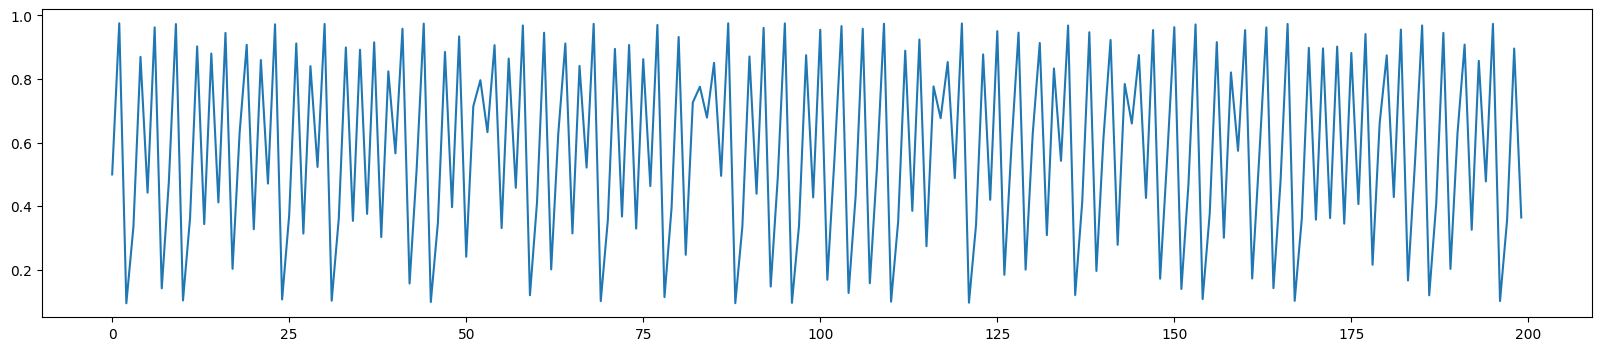

In [4]:
plt.figure(figsize=(20, 4))
_ = plt.plot(ts)

## 4. The setup
We use [spatial multiplexing](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.11.034021) by using 10 reservoirs. In addition we use temporal multiplexing, i.e., we train/predict using the last 10 observations.
Each reservoir has 3 qubits, where 2 are measured at each time step.
We also use [higher order observables](https://arxiv.org/pdf/2407.00445) set by the degree.

In [5]:
num_reservoirs = 10
num_qubits = 3
num_meas = 2
degree = num_meas
timeplex = 10

The classical reservoir should have the same number of neurons as the number of observables the quantum reservoirs use.
We use the en/decoding of classical data using [cosets](https://arxiv.org/pdf/2407.00445) of a given stabilizer.

In [6]:
res = {}
num_neurons = num_reservoirs * (2**num_meas - 1)
res["classical"] = Reservoir(num_neurons, lr=0.5, sr=0.9)

res["quantum_part"] = PartialMeasurement(
    num_qubits,
    num_meas,
    backend=AerSimulator(),
    degree=degree,
    num_reservoirs=num_reservoirs,
)

res["quantum_stab"] = Stabilizer(
    num_qubits,
    num_meas,
    backend=AerSimulator(),
    degree=degree,
    num_reservoirs=num_reservoirs,
)

## 5. Helper functions to fit the model and run predictions

In [7]:
def fit_model(model, res_states, series, WARMUP=0.3, timeplex=1):
    warmup = int(len(series) * WARMUP)

    X = res_states[warmup:-1]
    y = series[warmup + 1 :]

    if timeplex > 1:
        X = create_shifted_array(X, timeplex)
    model.fit(X, y)

    return model, X, y


def run_prediction(model, res_states, timeplex=1):
    X = np.copy(res_states)

    if timeplex > 1:
        X = create_shifted_array(X, timeplex)
    X = X[-1, :]
    X = X.reshape((1, -1))
    return model.predict(X)

## 6. Fit the model with linear regression and run the predictions
This will take some time!

In [8]:
prediction = {}
tscv = TimeSeriesSplit()
for method in ["classical", "quantum_part", "quantum_stab"]:
    for i, (train_index, test_index) in enumerate(tscv.split(ts)):
        if not i == 2:
            continue

        X_train = ts[train_index]
        X_test = ts[test_index]
        num_pred = len(test_index)
        linreg = Ridge(alpha=1e-7)
        if method == "classical":
            states = res[method].run(X_train.reshape(-1, 1), reset=True)
            linreg, X, y = fit_model(linreg, states, X_train)
        else:
            states = res[method].run(timeseries=X_train, shots=1e3, precision=1e-2)
            linreg, X, y = fit_model(linreg, states, X_train, timeplex=timeplex)

        score = linreg.score(X, y)
        print("score[", method, "]=", score)

        firsttime = True
        prediction[method] = X_train

        for j in range(num_pred):
            print(j, "/", num_pred)
            if method == "classical":
                if firsttime:
                    states = res[method].state()
                else:
                    states = res[method].run(prediction[method][-1])
                tmp = run_prediction(linreg, states, 1)
            else:
                states = res[method].run(
                    prediction[method][-2 * int(timeplex) :], shots=1e3, precision=1e-2
                )
                tmp = run_prediction(linreg, states, timeplex)

            prediction[method] = np.append(prediction[method], tmp)

            firsttime = False

Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 7702.83it/s]


score[ classical ]= 0.9971940011772895
0 / 33
1 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3300.00it/s]


2 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2721.81it/s]


3 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2613.27it/s]


4 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2534.32it/s]


5 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1689.21it/s]


6 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2657.99it/s]


7 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2737.80it/s]


8 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2685.21it/s]


9 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2304.56it/s]


10 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2704.26it/s]


11 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3398.95it/s]


12 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3310.42it/s]


13 / 33


Running Reservoir-0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 325.77it/s]


14 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2725.34it/s]


15 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2490.68it/s]


16 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2711.25it/s]


17 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2273.34it/s]


18 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2520.62it/s]


19 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1968.23it/s]


20 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2317.30it/s]


21 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2505.56it/s]


22 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2377.72it/s]


23 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2369.66it/s]


24 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1763.79it/s]


25 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2880.70it/s]


26 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3524.63it/s]


27 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2421.65it/s]


28 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3440.77it/s]


29 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3477.86it/s]


30 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3070.50it/s]


31 / 33


Running Reservoir-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2023.30it/s]


32 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:17<00:00, 13.78s/it]


score[ quantum_part ]= 0.9999999999999559
0 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.10s/it]


1 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.11s/it]


2 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.13s/it]


3 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.12s/it]


4 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.10s/it]


5 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.10s/it]


6 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.15s/it]


7 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.12s/it]


8 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.18s/it]


9 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.05s/it]


10 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.08s/it]


11 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.06s/it]


12 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.04s/it]


13 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.08s/it]


14 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.07s/it]


15 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.11s/it]


16 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.13s/it]


17 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.06s/it]


18 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.09s/it]


19 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.09s/it]


20 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.11s/it]


21 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.11s/it]


22 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.10s/it]


23 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.09s/it]


24 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.13s/it]


25 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.12s/it]


26 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.11s/it]


27 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.11s/it]


28 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.11s/it]


29 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.10s/it]


30 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.10s/it]


31 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.20s/it]


32 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:43<00:00, 16.38s/it]


score[ quantum_stab ]= 0.99999999999995
0 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.52s/it]


1 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.52s/it]


2 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.68s/it]


3 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.53s/it]


4 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.64s/it]


5 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.50s/it]


6 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.55s/it]


7 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.56s/it]


8 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.48s/it]


9 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.53s/it]


10 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.55s/it]


11 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.50s/it]


12 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.52s/it]


13 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.52s/it]


14 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.57s/it]


15 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.51s/it]


16 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.48s/it]


17 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.49s/it]


18 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.50s/it]


19 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.53s/it]


20 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.49s/it]


21 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.53s/it]


22 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.55s/it]


23 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.52s/it]


24 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.49s/it]


25 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.47s/it]


26 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.51s/it]


27 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.48s/it]


28 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.53s/it]


29 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.52s/it]


30 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.51s/it]


31 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.51s/it]


32 / 33


Running reservoirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.50s/it]


## 7. Plot the predictions

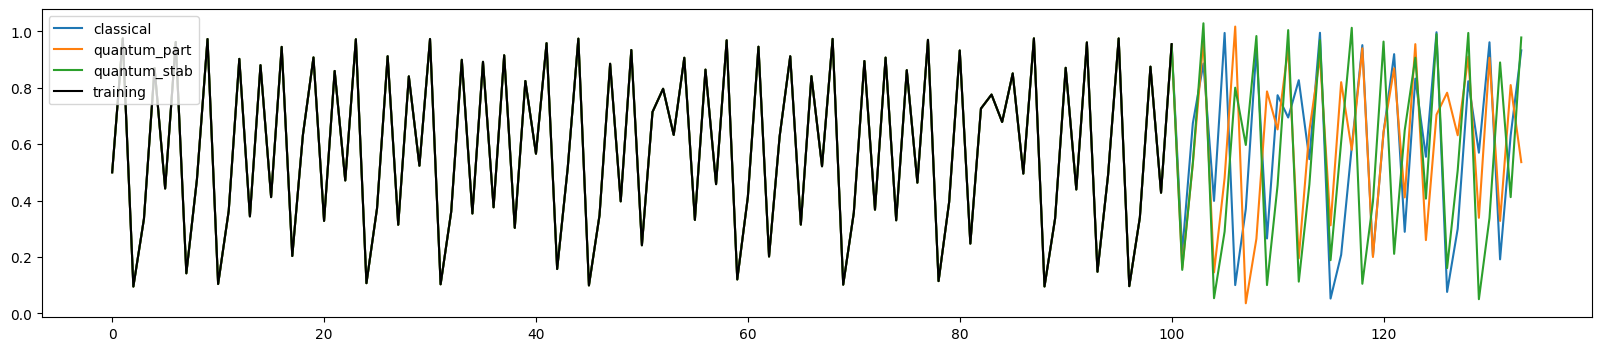

In [9]:
plt.figure(figsize=(20, 4))
for method in ["classical", "quantum_part", "quantum_stab"]:
    plt.plot(prediction[method], label=method)
plt.plot(X_train, "k", label="training")
plt.legend(loc="upper left")

## 8. [Poincaré plot](https://en.wikipedia.org/wiki/Poincar%C3%A9_plot) to see how well the logistic map was learned.

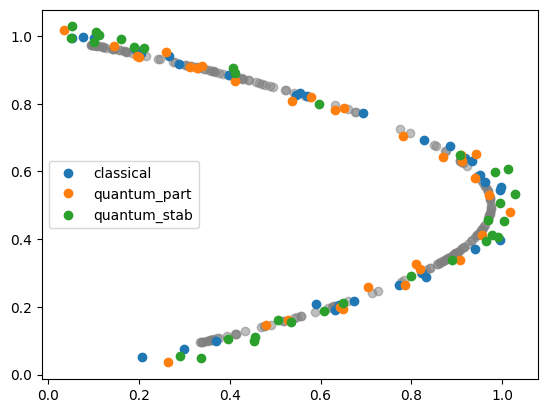

In [10]:
fig = plt.figure()
k = 1
plt.plot(ts[k:], ts[:-k], lw=0, color="gray", marker="o", alpha=0.5)

for method in ["classical", "quantum_part", "quantum_stab"]:
    tmp = prediction[method][len(X_train) :]
    plt.plot(tmp[k:], tmp[:-k], "o", label=method)

plt.legend(loc="center left")